# NBA Pace Analytics: Game-Level & Team-Level Analysis

## Overview
This notebook investigates the relationship between NBA team pace of play and thier offensive rating across three seasons (2023-24, 2024-25, 2025-26). We analyze whether faster-paced teams also improve offensively in efficiency and win more games.

## Table of Contents
1. **Setup & Configuration** — Imports and constants
2. **Data Acquisition** — Fetch game logs and team stats
3. **Feature Engineering & Team Aggregation** — Calculate PACE, ORTG, TS% and aggregated it to a team level
4. **Year-over-Year Analysis** — Calculate deltas and YoY changes
5. **Statistical Analysis (2025→2026)** — Pace impact on wins
6. **Comparative Analysis (2024→2025)** — Validation across periods
7. **Visualizations** — Plots and charts
8. **Results Summary** — Key findings

---

## 1. Setup & Configuration

In [52]:
# -------------------- Imports --------------------
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import leaguegamelog, LeagueDashTeamStats
from scipy.stats import ttest_ind

# -------------------- Load Pre-Processed Data --------------------
from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\kobyw\OneDrive\Documents\nba-pace-analytics").resolve()
PROC_DIR = PROJECT_ROOT / "data" / "processed"

# Load combined game logs with derived metrics (from 01_get_data.ipynb)
all_logs_df = pd.read_csv(PROC_DIR / "team_game_logs_with_metrics_2024_2026.csv")

# Load team season outcomes (Win%, PM/G from LeagueDashTeamStats)
team_outcomes_df = pd.read_csv(PROC_DIR / "team_season_outcomes_2024_2026.csv")

# -------------------- Split Data by Season --------------------
# Extract season-specific dataframes for easier access
log_2026 = all_logs_df[all_logs_df['SEASON'] == '2025-26'].copy()
log_2025 = all_logs_df[all_logs_df['SEASON'] == '2024-25'].copy()
log_2024 = all_logs_df[all_logs_df['SEASON'] == '2023-24'].copy()

wins_2026 = team_outcomes_df[team_outcomes_df['SEASON'] == '2025-26'].copy()
wins_2025 = team_outcomes_df[team_outcomes_df['SEASON'] == '2024-25'].copy()
wins_2024 = team_outcomes_df[team_outcomes_df['SEASON'] == '2023-24'].copy()

print(f"✓ Loaded game logs: {len(log_2026)} (2026), {len(log_2025)} (2025), {len(log_2024)} (2024) games")
print(f"✓ Loaded team outcomes: {len(wins_2026)} (2026), {len(wins_2025)} (2025), {len(wins_2024)} (2024) teams")

# -------------------- Configuration --------------------
MIN_GAMES_THRESHOLD = 0

✓ Loaded game logs: 568 (2026), 2460 (2025), 2460 (2024) games
✓ Loaded team outcomes: 30 (2026), 30 (2025), 30 (2024) teams


## 2. Data Acquisition

Fetch game logs and team statistics from the NBA API for all three seasons.

In [53]:
# -------------------- Helper Functions --------------------
def calculate_team_metric(
    game_logs_df: pd.DataFrame,
    metric_col: str,
    min_threshold: int = MIN_GAMES_THRESHOLD,
) -> pd.Series:
    """Return season-average metric by TEAM_NAME."""
    return (
        game_logs_df[game_logs_df["MIN"] > min_threshold]
        .groupby("TEAM_NAME")[metric_col]
        .mean()
    )

def make_abbrev(name):
    """Generate team abbreviation from team name (fallback)."""
    if not isinstance(name, str) or len(name) == 0:
        return ''
    parts = name.split()
    if len(parts) >= 2:
        return (''.join(p[0] for p in parts)[:3]).upper()
    return name[:3].upper()

# -------------------- Data Verification --------------------
print("\nSample game logs (2025-26):")
print(log_2026[['TEAM_NAME', 'PACE', 'ORTG', 'TS_PCT', 'MIN']].head(3))


Sample game logs (2025-26):
                  TEAM_NAME        PACE        ORTG    TS_PCT  MIN
4920        Houston Rockets  106.427586   96.423017  0.560376  290
4921  Golden State Warriors  105.800000  112.476371  0.655575  240
4922     Los Angeles Lakers  106.240000  102.597892  0.610166  240


## 3. Feature Engineering & Team Aggregation

Calculate game-level derived metrics for all seasons and season-long team averages for pace and efficiency metrics.

In [54]:
# -------------------- Compute Season-Average Pace --------------------
# Metrics already computed in 01_get_data.ipynb; here we aggregate to season level
pace_2026 = calculate_team_metric(log_2026, 'PACE', MIN_GAMES_THRESHOLD)
pace_2025 = calculate_team_metric(log_2025, 'PACE', MIN_GAMES_THRESHOLD)
pace_2024 = calculate_team_metric(log_2024, 'PACE', MIN_GAMES_THRESHOLD)

print("\n" + "="*70)
print("SEASON-AVERAGE PACE (possessions per 48 minutes)")
print("="*70)
print(f"  2024: {pace_2024.mean():.2f}")
print(f"  2025: {pace_2025.mean():.2f}")
print(f"  2026: {pace_2026.mean():.2f}")
print("="*70)


SEASON-AVERAGE PACE (possessions per 48 minutes)
  2024: 106.82
  2025: 107.61
  2026: 109.59


In [55]:
# -------------------- Team-Level Aggregation --------------------
# Compute team averages for all key metrics
team_pace_2026 = calculate_team_metric(log_2026, 'PACE', MIN_GAMES_THRESHOLD).sort_values(ascending=False)
team_pace_2025 = calculate_team_metric(log_2025, 'PACE', MIN_GAMES_THRESHOLD).sort_values(ascending=False)
team_pace_2024 = calculate_team_metric(log_2024, 'PACE', MIN_GAMES_THRESHOLD).sort_values(ascending=False)

team_ortg_2026 = calculate_team_metric(log_2026, 'ORTG', MIN_GAMES_THRESHOLD)
team_ortg_2025 = calculate_team_metric(log_2025, 'ORTG', MIN_GAMES_THRESHOLD)
team_ortg_2024 = calculate_team_metric(log_2024, 'ORTG', MIN_GAMES_THRESHOLD)

team_ts_2026 = calculate_team_metric(log_2026, 'TS_PCT', MIN_GAMES_THRESHOLD) * 100
team_ts_2025 = calculate_team_metric(log_2025, 'TS_PCT', MIN_GAMES_THRESHOLD) * 100
team_ts_2024 = calculate_team_metric(log_2024, 'TS_PCT', MIN_GAMES_THRESHOLD) * 100

team_3pa_2026 = calculate_team_metric(log_2026, 'FG3A', MIN_GAMES_THRESHOLD)
team_3pa_2025 = calculate_team_metric(log_2025, 'FG3A', MIN_GAMES_THRESHOLD)
team_3pa_2024 = calculate_team_metric(log_2024, 'FG3A', MIN_GAMES_THRESHOLD)

print("\nTop 5 teams by PACE (2026):")
print(team_pace_2026.head())


Top 5 teams by PACE (2026):
TEAM_NAME
Portland Trail Blazers    114.789076
Miami Heat                113.797378
Utah Jazz                 112.437619
Chicago Bulls             111.667280
Indiana Pacers            111.463303
Name: PACE, dtype: float64


In [56]:
# -------------------- Build Comprehensive Team Comparison DataFrame --------------------
team_pace_comparison = pd.DataFrame({
    'PACE_2024': team_pace_2024,
    'PACE_2025': team_pace_2025,
    'PACE_2026': team_pace_2026,
    'ORTG_2024': team_ortg_2024,
    'ORTG_2025': team_ortg_2025,
    'ORTG_2026': team_ortg_2026,
    'TS_PCT_2024': team_ts_2024,
    'TS_PCT_2025': team_ts_2025,
    'TS_PCT_2026': team_ts_2026,
    '3PA_2024': team_3pa_2024,
    '3PA_2025': team_3pa_2025,
    '3PA_2026': team_3pa_2026,
})

print("\nTeam Pace Comparison (sample):")
print(team_pace_comparison.head())


Team Pace Comparison (sample):
                    PACE_2024   PACE_2025   PACE_2026   ORTG_2024   ORTG_2025  \
TEAM_NAME                                                                       
Atlanta Hawks      109.787600  111.729204  108.976000  106.909837  105.387129   
Boston Celtics     105.505559  104.484777  108.332632  113.591991  110.648330   
Brooklyn Nets      105.708504  105.044004  106.902222  103.776242   99.759729   
Charlotte Hornets  104.502862  107.531192  110.211559  101.851318   97.445182   
Chicago Bulls      104.498927  110.511882  111.667280  105.933325  106.384787   

                    ORTG_2026  TS_PCT_2024  TS_PCT_2025  TS_PCT_2026  \
TEAM_NAME                                                              
Atlanta Hawks      108.201630    57.721070    58.098995    60.010721   
Boston Celtics     109.537686    60.974126    59.162482    57.577024   
Brooklyn Nets      101.895710    56.228170    55.344414    56.380748   
Charlotte Hornets  104.460635    56.2220

In [57]:
# -------------------- Year-over-Year Analysis --------------------
# PACE changes
team_pace_comparison['PACE_YoY_25_26'] = ((team_pace_comparison['PACE_2026'] - team_pace_comparison['PACE_2025']) / team_pace_comparison['PACE_2025'] * 100)
team_pace_comparison['PACE_YoY_24_25'] = ((team_pace_comparison['PACE_2025'] - team_pace_comparison['PACE_2024']) / team_pace_comparison['PACE_2024'] * 100)
team_pace_comparison['PACE_YoY_24_26'] = ((team_pace_comparison['PACE_2026'] - team_pace_comparison['PACE_2024']) / team_pace_comparison['PACE_2024'] * 100)

# ORTG changes (percent)
team_pace_comparison['ORTG_YoY_25_26'] = ((team_pace_comparison['ORTG_2026'] - team_pace_comparison['ORTG_2025']) / team_pace_comparison['ORTG_2025']) * 100
team_pace_comparison['ORTG_YoY_24_25'] = ((team_pace_comparison['ORTG_2025'] - team_pace_comparison['ORTG_2024']) / team_pace_comparison['ORTG_2024']) * 100

# TS% changes (absolute points)
team_pace_comparison['TS_YoY_25_26'] = team_pace_comparison['TS_PCT_2026'] - team_pace_comparison['TS_PCT_2025']
team_pace_comparison['TS_YoY_24_25'] = team_pace_comparison['TS_PCT_2025'] - team_pace_comparison['TS_PCT_2024']

# 3PA changes (percent)
team_pace_comparison['3PA_YoY_25_26'] = ((team_pace_comparison['3PA_2026'] - team_pace_comparison['3PA_2025']) / team_pace_comparison['3PA_2025']) * 100
team_pace_comparison['3PA_YoY_24_25'] = ((team_pace_comparison['3PA_2025'] - team_pace_comparison['3PA_2024']) / team_pace_comparison['3PA_2024']) * 100

# Show top movers
print("\nTop 5 pace accelerators (2025→2026):")
print(team_pace_comparison.nlargest(5, 'PACE_YoY_25_26')[['PACE_2025', 'PACE_2026', 'PACE_YoY_25_26']])

print("\nTop 5 pace decelerators (2025→2026):")
print(team_pace_comparison.nsmallest(5, 'PACE_YoY_25_26')[['PACE_2025', 'PACE_2026', 'PACE_YoY_25_26']])


Top 5 pace accelerators (2025→2026):
                         PACE_2025   PACE_2026  PACE_YoY_25_26
TEAM_NAME                                                     
Miami Heat              103.941672  113.797378        9.481959
Phoenix Suns            104.474524  109.872981        5.167248
Portland Trail Blazers  109.498113  114.789076        4.832013
Orlando Magic           104.975257  109.743132        4.541904
Minnesota Timberwolves  105.959088  110.697319        4.471755

Top 5 pace decelerators (2025→2026):
                        PACE_2025   PACE_2026  PACE_YoY_25_26
TEAM_NAME                                                    
Memphis Grizzlies      113.444556  110.338755       -2.737726
Atlanta Hawks          111.729204  108.976000       -2.464176
Oklahoma City Thunder  108.559301  106.999931       -1.436422
Houston Rockets        110.237902  109.200215       -0.941316
LA Clippers            105.532490  104.712377       -0.777118


In [58]:
# -------------------- Select Top & Bottom Teams by Pace Change --------------------
columns_to_select = [
    'PACE_2026', 'PACE_YoY_25_26',
    'ORTG_2026', 'ORTG_YoY_25_26',
    'TS_PCT_2026', 'TS_YoY_25_26',
    '3PA_2026', '3PA_YoY_25_26'
]

top_5_pace = team_pace_comparison.nlargest(5, 'PACE_YoY_25_26')[columns_to_select]
bottom_5_pace = team_pace_comparison.nsmallest(5, 'PACE_YoY_25_26')[columns_to_select]

print("\nTop 5 Teams by Pace Increase:")
print(top_5_pace.round(2))

print("\nBottom 5 Teams by Pace Decrease:")
print(bottom_5_pace.round(2))


Top 5 Teams by Pace Increase:
                        PACE_2026  PACE_YoY_25_26  ORTG_2026  ORTG_YoY_25_26  \
TEAM_NAME                                                                      
Miami Heat                 113.80            9.48     107.31            2.01   
Phoenix Suns               109.87            5.17     105.93           -1.90   
Portland Trail Blazers     114.79            4.83     102.78            1.75   
Orlando Magic              109.74            4.54     108.26            7.98   
Minnesota Timberwolves     110.70            4.47     109.81            2.44   

                        TS_PCT_2026  TS_YoY_25_26  3PA_2026  3PA_YoY_25_26  
TEAM_NAME                                                                   
Miami Heat                    58.71          0.90     35.63          -4.52  
Phoenix Suns                  58.91         -0.74     40.10           5.66  
Portland Trail Blazers        56.42          0.75     42.00          11.28  
Orlando Magic          

## 5. Year-over-Year Analysis

Calculate year-over-year changes in pace, efficiency, and performance.

In [59]:
# Already displayed in previous cell; this cell shows detail
print("\n" + "="*70)
print("TOP 5 PACE ACCELERATORS (Fastest Pace Increase)")
print("="*70)
print(top_5_pace.to_string())


TOP 5 PACE ACCELERATORS (Fastest Pace Increase)
                         PACE_2026  PACE_YoY_25_26   ORTG_2026  ORTG_YoY_25_26  TS_PCT_2026  TS_YoY_25_26   3PA_2026  3PA_YoY_25_26
TEAM_NAME                                                                                                                          
Miami Heat              113.797378        9.481959  107.312319        2.010755    58.710258      0.900702  35.631579      -4.516684
Phoenix Suns            109.872981        5.167248  105.933143       -1.895982    58.909784     -0.743006  40.100000       5.661954
Portland Trail Blazers  114.789076        4.832013  102.783524        1.754426    56.424700      0.746877  42.000000      11.276252
Orlando Magic           109.743132        4.541904  108.262555        7.984900    59.227298      4.192813  32.700000      -7.282158
Minnesota Timberwolves  110.697319        4.471755  109.814365        2.439693    60.850711      1.835827  35.368421     -11.281416


In [60]:
# Already displayed in previous cell; this cell shows detail
print("\n" + "="*70)
print("BOTTOM 5 PACE DECELERATORS (Biggest Pace Decrease)")
print("="*70)
print(bottom_5_pace.to_string())


BOTTOM 5 PACE DECELERATORS (Biggest Pace Decrease)
                        PACE_2026  PACE_YoY_25_26   ORTG_2026  ORTG_YoY_25_26  TS_PCT_2026  TS_YoY_25_26   3PA_2026  3PA_YoY_25_26
TEAM_NAME                                                                                                                         
Memphis Grizzlies      110.338755       -2.737726  102.187612       -4.715150    55.667710     -3.171156  39.900000       5.338055
Atlanta Hawks          108.976000       -2.464176  108.201630        2.670630    60.010721      1.911726  36.800000      -2.311428
Oklahoma City Thunder  106.999931       -1.436422  112.030864        1.084643    60.910142      1.584226  37.900000      -2.393216
Houston Rockets        109.200215       -0.941316  109.136474        5.825519    58.842119      3.518002  30.875000     -13.827434
LA Clippers            104.712377       -0.777118  105.765475       -0.637850    59.354597      0.343265  36.526316       9.392180

BOTTOM 5 PACE DECELERATORS (Bi

In [61]:
# -------------------- Option B: Correlation Analysis (2025→2026) --------------------

# Compute deltas (change from 2025 to 2026)
pace_delta = team_pace_2026 - team_pace_2025
ortg_delta = team_ortg_2026 - team_ortg_2025
ts_delta = team_ts_2026 - team_ts_2025

# Create analysis dataframe
analysis_df = pd.DataFrame({
    'PACE_DELTA': pace_delta,
    'ORTG_DELTA': ortg_delta,
    'TS_DELTA': ts_delta
}).dropna()

print("="*70)
print("PACE DELTA ANALYSIS SUMMARY (2025→2026)")
print("="*70)
print(analysis_df.describe().round(3))

# Create percentile-based buckets
q25 = analysis_df['PACE_DELTA'].quantile(0.25)
q75 = analysis_df['PACE_DELTA'].quantile(0.75)

def pace_bucket(x):
    if x >= q75:
        return 'Fastest 25%'
    elif x <= q25:
        return 'Slowest 25%'
    else:
        return 'Middle 50%'

analysis_df['PACE_BUCKET'] = analysis_df['PACE_DELTA'].apply(pace_bucket)

print("\nBucket Distribution:")
print(analysis_df['PACE_BUCKET'].value_counts())

# Group-level summary
bucket_summary = analysis_df.groupby('PACE_BUCKET').agg({
    'PACE_DELTA': 'mean',
    'ORTG_DELTA': 'mean',
    'TS_DELTA': 'mean'
}).round(3)

print("\n" + "="*70)
print("AVERAGE CHANGES BY PACE BUCKET")
print("="*70)
print(bucket_summary)

# Correlations
pace_ortg_corr = analysis_df['PACE_DELTA'].corr(analysis_df['ORTG_DELTA'])
pace_ts_corr = analysis_df['PACE_DELTA'].corr(analysis_df['TS_DELTA'])

print("\n" + "="*70)
print("CORRELATIONS: PACE vs EFFICIENCY")
print("="*70)
print(f"  PACE Δ vs ORTG Δ: {pace_ortg_corr:7.3f}")
print(f"  PACE Δ vs TS% Δ:  {pace_ts_corr:7.3f}")
print("="*70)

# T-tests for statistical significance
fast = analysis_df[analysis_df['PACE_BUCKET'] == 'Fastest 25%']
slow = analysis_df[analysis_df['PACE_BUCKET'] == 'Slowest 25%']

t_ortg, p_ortg = ttest_ind(fast['ORTG_DELTA'], slow['ORTG_DELTA'], equal_var=False)
t_ts, p_ts = ttest_ind(fast['TS_DELTA'], slow['TS_DELTA'], equal_var=False)

print("\nT-TESTS (Fastest 25% vs Slowest 25%):")
print(f"  ORTG Δ: t={t_ortg:.3f}, p={p_ortg:.4f}")
print(f"  TS% Δ:  t={t_ts:.3f}, p={p_ts:.4f}")

# Case studies
fastest = analysis_df.sort_values('PACE_DELTA', ascending=False).head(5)
slowest = analysis_df.sort_values('PACE_DELTA', ascending=True).head(5)

print("\nFastest Pace Increasers (Top 5):")
print(fastest[['PACE_DELTA', 'ORTG_DELTA', 'TS_DELTA', 'PACE_BUCKET']].round(2))

print("\nBiggest Pace Decreasers (Bottom 5):")
print(slowest[['PACE_DELTA', 'ORTG_DELTA', 'TS_DELTA', 'PACE_BUCKET']].round(2))

PACE DELTA ANALYSIS SUMMARY (2025→2026)
       PACE_DELTA  ORTG_DELTA  TS_DELTA
count      30.000      30.000    30.000
mean        1.980       0.847     0.686
std         2.743       4.464     2.456
min        -3.106     -10.966    -6.166
25%         0.196      -0.895    -0.036
50%         2.138       1.792     0.824
75%         3.780       2.893     1.973
max         9.856       8.511     4.541

Bucket Distribution:
PACE_BUCKET
Middle 50%     14
Slowest 25%     8
Fastest 25%     8
Name: count, dtype: int64

AVERAGE CHANGES BY PACE BUCKET
             PACE_DELTA  ORTG_DELTA  TS_DELTA
PACE_BUCKET                                  
Fastest 25%       5.273       0.274    -0.076
Middle 50%        1.913       0.532     0.747
Slowest 25%      -1.196       1.972     1.339

CORRELATIONS: PACE vs EFFICIENCY
  PACE Δ vs ORTG Δ:  -0.087
  PACE Δ vs TS% Δ:   -0.157

T-TESTS (Fastest 25% vs Slowest 25%):
  ORTG Δ: t=-0.693, p=0.5003
  TS% Δ:  t=-1.049, p=0.3128

Fastest Pace Increasers (Top 5):
   

## 6. Statistical Analysis: Pace Impact (2025→2026)

Analyze correlations between pace changes, efficiency gains, and winning. 

**Approach:**
- Compute year-over-year deltas (2025→2026)
- Bucket teams into Fastest 25%, Middle 50%, Slowest 25%
- Calculate Pearson correlations (PACE ↔ ORTG/TS%, PACE ↔ Win%)
- Run independent t-tests for significance

In [ ]:
# -------------------- Correlation Analysis (2025→2026) --------------------

# Compute deltas (change from 2025 to 2026)
pace_delta = team_pace_2026 - team_pace_2025
ortg_delta = team_ortg_2026 - team_ortg_2025
ts_delta = team_ts_2026 - team_ts_2025

# Create analysis dataframe
analysis_df = pd.DataFrame({
    'PACE_DELTA': pace_delta,
    'ORTG_DELTA': ortg_delta,
    'TS_DELTA': ts_delta
}).dropna()

print("="*70)
print("PACE DELTA ANALYSIS SUMMARY (2025→2026)")
print("="*70)
print(analysis_df.describe().round(3))

# Create percentile-based buckets
q25 = analysis_df['PACE_DELTA'].quantile(0.25)
q75 = analysis_df['PACE_DELTA'].quantile(0.75)

def pace_bucket(x):
    if x >= q75:
        return 'Fastest 25%'
    elif x <= q25:
        return 'Slowest 25%'
    else:
        return 'Middle 50%'

analysis_df['PACE_BUCKET'] = analysis_df['PACE_DELTA'].apply(pace_bucket)

print("\nBucket Distribution:")
print(analysis_df['PACE_BUCKET'].value_counts())

# Group-level summary
bucket_summary = analysis_df.groupby('PACE_BUCKET').agg({
    'PACE_DELTA': 'mean',
    'ORTG_DELTA': 'mean',
    'TS_DELTA': 'mean'
}).round(3)

print("\n" + "="*70)
print("AVERAGE CHANGES BY PACE BUCKET")
print("="*70)
print(bucket_summary)

# Correlations
pace_ortg_corr = analysis_df['PACE_DELTA'].corr(analysis_df['ORTG_DELTA'])
pace_ts_corr = analysis_df['PACE_DELTA'].corr(analysis_df['TS_DELTA'])

print("\n" + "="*70)
print("CORRELATIONS: PACE vs EFFICIENCY")
print("="*70)
print(f"  PACE Δ vs ORTG Δ: {pace_ortg_corr:7.3f}")
print(f"  PACE Δ vs TS% Δ:  {pace_ts_corr:7.3f}")
print("="*70)

# T-tests for statistical significance
fast = analysis_df[analysis_df['PACE_BUCKET'] == 'Fastest 25%']
slow = analysis_df[analysis_df['PACE_BUCKET'] == 'Slowest 25%']

t_ortg, p_ortg = ttest_ind(fast['ORTG_DELTA'], slow['ORTG_DELTA'], equal_var=False)
t_ts, p_ts = ttest_ind(fast['TS_DELTA'], slow['TS_DELTA'], equal_var=False)

print("\nT-TESTS (Fastest 25% vs Slowest 25%):")
print(f"  ORTG Δ: t={t_ortg:.3f}, p={p_ortg:.4f}")
print(f"  TS% Δ:  t={t_ts:.3f}, p={p_ts:.4f}")

# Case studies
fastest = analysis_df.sort_values('PACE_DELTA', ascending=False).head(5)
slowest = analysis_df.sort_values('PACE_DELTA', ascending=True).head(5)

print("\nFastest Pace Increasers (Top 5):")
print(fastest[['PACE_DELTA', 'ORTG_DELTA', 'TS_DELTA', 'PACE_BUCKET']].round(2))

print("\nBiggest Pace Decreasers (Bottom 5):")
print(slowest[['PACE_DELTA', 'ORTG_DELTA', 'TS_DELTA', 'PACE_BUCKET']].round(2))

In [62]:
# -------------------- Add Team Abbreviations for Plotting --------------------
# Build mapping from TEAM_NAME -> TEAM_ABBREVIATION from game logs
pairs = []
for df in [log_2026, log_2025, log_2024]:
    if 'TEAM_ABBREVIATION' in df.columns:
        pairs.append(df[['TEAM_NAME', 'TEAM_ABBREVIATION']].drop_duplicates())

if pairs:
    mapping_df = pd.concat(pairs, ignore_index=True).drop_duplicates()
    team_abbrev_map = dict(zip(mapping_df['TEAM_NAME'], mapping_df['TEAM_ABBREVIATION']))
else:
    team_abbrev_map = {}

# Add abbreviations to analysis_df
analysis_df['ABBREV'] = analysis_df.index.map(
    lambda name: team_abbrev_map.get(name, make_abbrev(name))
)

# Add to team_pace_comparison
team_pace_comparison['ABBREV'] = team_pace_comparison.index.map(
    lambda name: team_abbrev_map.get(name, make_abbrev(name))
)

print("Sample abbreviation mappings:")
print(analysis_df[['PACE_DELTA', 'ORTG_DELTA', 'ABBREV']].head())

Sample abbreviation mappings:
                   PACE_DELTA  ORTG_DELTA ABBREV
TEAM_NAME                                       
Atlanta Hawks       -2.753204    2.814500    ATL
Boston Celtics       3.847855   -1.110644    BOS
Brooklyn Nets        1.858219    2.135982    BKN
Charlotte Hornets    2.680367    7.015453    CHA
Chicago Bulls        1.155398    0.830683    CHI

                   PACE_DELTA  ORTG_DELTA ABBREV
TEAM_NAME                                       
Atlanta Hawks       -2.753204    2.814500    ATL
Boston Celtics       3.847855   -1.110644    BOS
Brooklyn Nets        1.858219    2.135982    BKN
Charlotte Hornets    2.680367    7.015453    CHA
Chicago Bulls        1.155398    0.830683    CHI


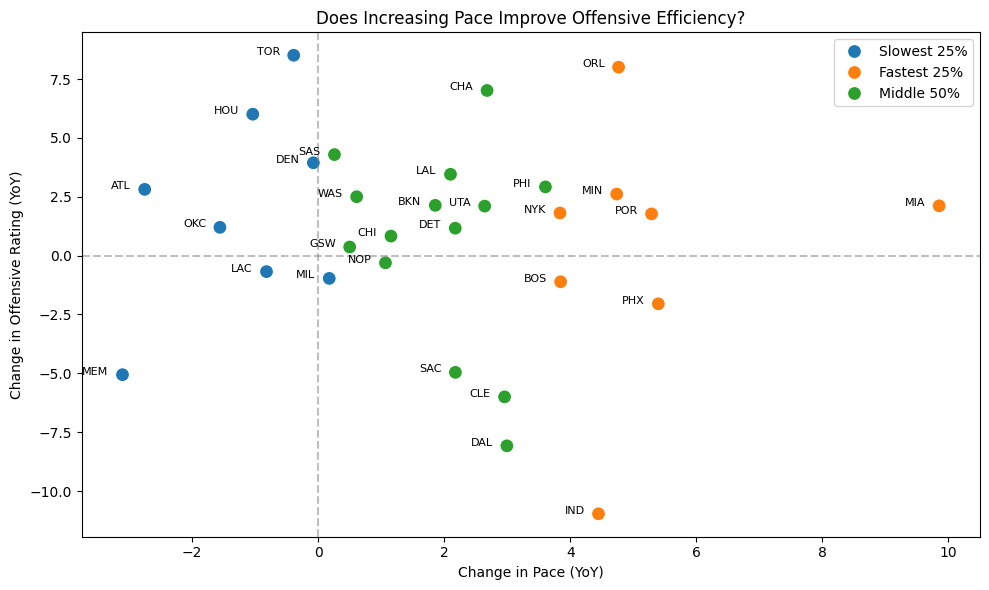

In [63]:
# -------------------- Visualization --------------------
# Scatter plot: PACE_DELTA vs ORTG_DELTA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=analysis_df, x='PACE_DELTA', y='ORTG_DELTA', hue='PACE_BUCKET', s=100)
plt.title("Does Increasing Pace Improve Offensive Efficiency?")
plt.xlabel("Change in Pace (YoY)")
plt.ylabel("Change in Offensive Rating (YoY)")
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.legend()

# Add team abbreviations as labels to the left of each point
for team in analysis_df.index:
    plt.annotate(analysis_df.loc[team, 'ABBREV'],
                 (analysis_df.loc[team, 'PACE_DELTA'], analysis_df.loc[team, 'ORTG_DELTA']),
                 xytext=(-10, 0), textcoords='offset points', fontsize=8, ha='right')

plt.tight_layout()
plt.show()

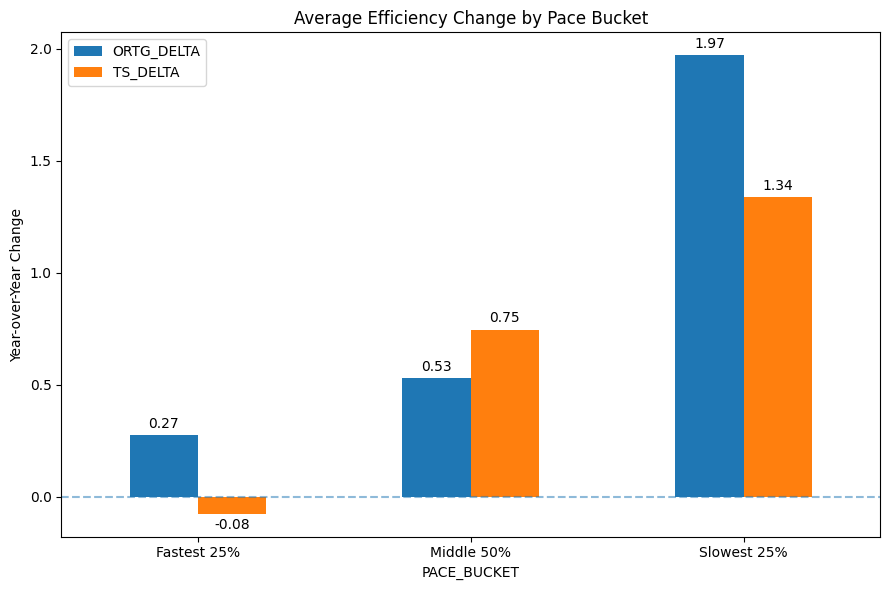

In [64]:
# Bar plot: Average ORTG_DELTA and TS_DELTA by PACE_BUCKET
bucket_summary[['ORTG_DELTA', 'TS_DELTA']].plot(kind='bar', figsize=(9,6))
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.2f", padding=3)
plt.title("Average Efficiency Change by Pace Bucket")
plt.ylabel("Year-over-Year Change")
plt.xticks(rotation=0)
plt.axhline(0, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [65]:
# -------------------- Statistical Testing --------------------
# Separate fastest and slowest 25% groups

fast = analysis_df[analysis_df["PACE_BUCKET"] == "Fastest 25%"]
slow = analysis_df[analysis_df["PACE_BUCKET"] == "Slowest 25%"]

# ORTG t-test
t_ortg, p_ortg = ttest_ind(
    fast["ORTG_DELTA"],
    slow["ORTG_DELTA"],
    equal_var=False
)

# TS% t-test
t_ts, p_ts = ttest_ind(
    fast["TS_DELTA"],
    slow["TS_DELTA"],
    equal_var=False
)

print(f"ORTG t-statistic: {t_ortg:.3f}, p-value: {p_ortg:.4f}")
print(f"TS% t-statistic:  {t_ts:.3f}, p-value: {p_ts:.4f}")

ORTG t-statistic: -0.693, p-value: 0.5003
TS% t-statistic:  -1.049, p-value: 0.3128


In [66]:
# -------------------- Prepare Win Percentage & Point Differential Data --------------------

# Rename columns for clarity and merge by season
wins_2026_prep = wins_2026.rename(columns={'W_PCT': 'W_PCT_2026', 'GP': 'GP_2026', 'PLUS_MINUS': 'PM_2026'})
wins_2025_prep = wins_2025.rename(columns={'W_PCT': 'W_PCT_2025', 'GP': 'GP_2025', 'PLUS_MINUS': 'PM_2025'})
wins_2024_prep = wins_2024.rename(columns={'W_PCT': 'W_PCT_2024', 'GP': 'GP_2024', 'PLUS_MINUS': 'PM_2024'})

# Merge all seasons
wins_df = wins_2026_prep[['TEAM_NAME', 'W_PCT_2026', 'GP_2026', 'PM_2026']].copy()
wins_df = wins_df.merge(wins_2025_prep[['TEAM_NAME', 'W_PCT_2025', 'GP_2025', 'PM_2025']], on='TEAM_NAME')
wins_df = wins_df.merge(wins_2024_prep[['TEAM_NAME', 'W_PCT_2024', 'GP_2024', 'PM_2024']], on='TEAM_NAME')

# Calculate deltas and per-game metrics
wins_df['WIN_PCT_DELTA_26_25'] = wins_df['W_PCT_2026'] - wins_df['W_PCT_2025']
wins_df['WIN_PCT_DELTA_25_24'] = wins_df['W_PCT_2025'] - wins_df['W_PCT_2024']

wins_df['PM_PG_2026'] = wins_df['PM_2026'] / wins_df['GP_2026']
wins_df['PM_PG_2025'] = wins_df['PM_2025'] / wins_df['GP_2025']
wins_df['PM_PG_2024'] = wins_df['PM_2024'] / wins_df['GP_2024']

wins_df['PM_PG_DELTA_26_25'] = wins_df['PM_PG_2026'] - wins_df['PM_PG_2025']
wins_df['PM_PG_DELTA_25_24'] = wins_df['PM_PG_2025'] - wins_df['PM_PG_2024']

print("\nWin % Changes (2025→2026):")
print(wins_df[['TEAM_NAME', 'W_PCT_2025', 'W_PCT_2026', 'WIN_PCT_DELTA_26_25']].sort_values('WIN_PCT_DELTA_26_25', ascending=False).head())


Win % Changes (2025→2026):
             TEAM_NAME  W_PCT_2025  W_PCT_2026  WIN_PCT_DELTA_26_25
27     Toronto Raptors       0.366       0.737                0.371
26   San Antonio Spurs       0.415       0.722                0.307
22  Philadelphia 76ers       0.293       0.556                0.263
8      Detroit Pistons       0.537       0.789                0.252
15          Miami Heat       0.451       0.684                0.233


In [67]:
# -------------------- Merge Pace/Efficiency Changes with Win Data --------------------
# Add wins data to analysis_df for correlation analysis
analysis_df = analysis_df.reset_index().merge(
    wins_df[['TEAM_NAME', 'WIN_PCT_DELTA_26_25', 'PM_PG_DELTA_26_25', 'WIN_PCT_DELTA_25_24', 'PM_PG_DELTA_25_24']],
    on='TEAM_NAME',
    how='left'
).set_index('TEAM_NAME')

print("\nAnalysis DF with wins data (sample):")
print(analysis_df[['PACE_DELTA', 'ORTG_DELTA', 'TS_DELTA', 'WIN_PCT_DELTA_26_25']].head())


Analysis DF with wins data (sample):
                   PACE_DELTA  ORTG_DELTA  TS_DELTA  WIN_PCT_DELTA_26_25
TEAM_NAME                                                               
Atlanta Hawks       -2.753204    2.814500  1.911726                0.112
Boston Celtics       3.847855   -1.110644 -1.585458               -0.188
Brooklyn Nets        1.858219    2.135982  1.036333               -0.150
Charlotte Hornets    2.680367    7.015453  4.142426                0.031
Chicago Bulls        1.155398    0.830683  0.582647                0.024


In [68]:
# -------------------- Correlations: Pace/Efficiency Changes vs Win Performance --------------------
wins_pace_corr = analysis_df['WIN_PCT_DELTA_26_25'].corr(analysis_df['PACE_DELTA'])
wins_ortg_corr = analysis_df['WIN_PCT_DELTA_26_25'].corr(analysis_df['ORTG_DELTA'])
wins_ts_corr = analysis_df['WIN_PCT_DELTA_26_25'].corr(analysis_df['TS_DELTA'])

pm_pace_corr = analysis_df['PM_PG_DELTA_26_25'].corr(analysis_df['PACE_DELTA'])
pm_ortg_corr = analysis_df['PM_PG_DELTA_26_25'].corr(analysis_df['ORTG_DELTA'])
pm_ts_corr = analysis_df['PM_PG_DELTA_26_25'].corr(analysis_df['TS_DELTA'])

print("\n" + "="*70)
print("CORRELATIONS: METRIC CHANGES vs WINNING CHANGES (2025→2026)")
print("="*70)
print("\nWin Percentage Correlations:")
print(f"  PACE Δ vs WIN% Δ: {wins_pace_corr:7.3f}")
print(f"  ORTG Δ vs WIN% Δ: {wins_ortg_corr:7.3f}")
print(f"  TS% Δ  vs WIN% Δ: {wins_ts_corr:7.3f}")
print("\nPoint Differential Per Game Correlations:")
print(f"  PACE Δ vs PM/G Δ: {pm_pace_corr:7.3f}")
print(f"  ORTG Δ vs PM/G Δ: {pm_ortg_corr:7.3f}")
print(f"  TS% Δ  vs PM/G Δ: {pm_ts_corr:7.3f}")
print("="*70)


CORRELATIONS: METRIC CHANGES vs WINNING CHANGES (2025→2026)

Win Percentage Correlations:
  PACE Δ vs WIN% Δ:   0.057
  ORTG Δ vs WIN% Δ:   0.732
  TS% Δ  vs WIN% Δ:   0.700

Point Differential Per Game Correlations:
  PACE Δ vs PM/G Δ:   0.096
  ORTG Δ vs PM/G Δ:   0.783
  TS% Δ  vs PM/G Δ:   0.740


### Correlations: 2025→2026 Period

Correlate pace/efficiency changes with win percentage and point differential changes.

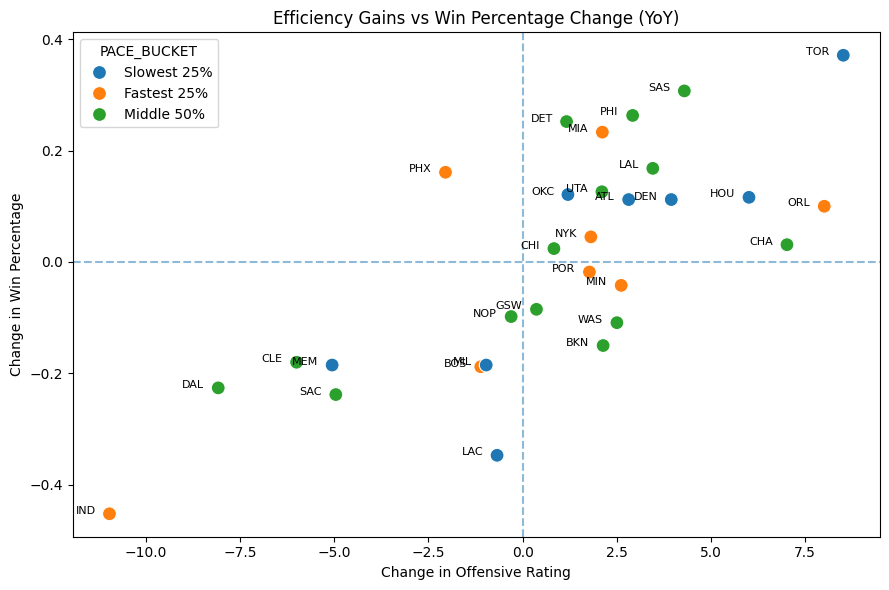

In [69]:
# Recreate the scatter with annotations (annotations must be added before plt.show())
plt.figure(figsize=(9,6))
ax = sns.scatterplot(
    data=analysis_df,
    x="ORTG_DELTA",
    y="WIN_PCT_DELTA_26_25",
    hue="PACE_BUCKET",
    s=100,
    legend='full'
)

ax.axhline(0, linestyle="--", alpha=0.5)
ax.axvline(0, linestyle="--", alpha=0.5)

# Add team abbreviations as labels (skip rows with NaNs)
for team, row in analysis_df.dropna(subset=["ORTG_DELTA", "WIN_PCT_DELTA_26_25"]).iterrows():
    abbrev = row['ABBREV'] if 'ABBREV' in analysis_df.columns else team[:3].upper()
    ax.annotate(
        abbrev,
        (row["ORTG_DELTA"], row["WIN_PCT_DELTA_26_25"]),
        xytext=(-10, 0),
        textcoords='offset points',
        fontsize=8,
        ha='right'
    )

plt.title("Efficiency Gains vs Win Percentage Change (YoY)")
plt.xlabel("Change in Offensive Rating")
plt.ylabel("Change in Win Percentage")
plt.tight_layout()
plt.show()

## 7. Comparative Analysis: Pace Impact (2024→2025)

Repeat the analysis for the 2024→2025 period to validate findings across multiple seasons.

This allows us to determine if the relationships are **consistent** or **season-dependent**.

In [70]:
# -------------------- Comparative Analysis: 2024→2025 Period --------------------
# Compute deltas for prior season
pace_delta_24_25 = team_pace_2025 - team_pace_2024
ortg_delta_24_25 = team_ortg_2025 - team_ortg_2024
ts_delta_24_25 = team_ts_2025 - team_ts_2024

analysis_df_24_25 = pd.DataFrame({
    'PACE_DELTA': pace_delta_24_25,
    'ORTG_DELTA': ortg_delta_24_25,
    'TS_DELTA': ts_delta_24_25
}).dropna()

# Merge with wins data
analysis_df_24_25 = analysis_df_24_25.reset_index().merge(
    wins_df[['TEAM_NAME', 'WIN_PCT_DELTA_25_24', 'PM_PG_DELTA_25_24']],
    on='TEAM_NAME',
    how='left'
).set_index('TEAM_NAME')

# Correlations for 2024→2025
wins_pace_corr_24_25 = analysis_df_24_25['WIN_PCT_DELTA_25_24'].corr(analysis_df_24_25['PACE_DELTA'])
wins_ortg_corr_24_25 = analysis_df_24_25['WIN_PCT_DELTA_25_24'].corr(analysis_df_24_25['ORTG_DELTA'])
wins_ts_corr_24_25 = analysis_df_24_25['WIN_PCT_DELTA_25_24'].corr(analysis_df_24_25['TS_DELTA'])

pm_pace_corr_24_25 = analysis_df_24_25['PM_PG_DELTA_25_24'].corr(analysis_df_24_25['PACE_DELTA'])
pm_ortg_corr_24_25 = analysis_df_24_25['PM_PG_DELTA_25_24'].corr(analysis_df_24_25['ORTG_DELTA'])
pm_ts_corr_24_25 = analysis_df_24_25['PM_PG_DELTA_25_24'].corr(analysis_df_24_25['TS_DELTA'])

print("\n" + "="*70)
print("CORRELATIONS: METRIC CHANGES vs WINNING CHANGES (2024→2025)")
print("="*70)
print("\nWin Percentage Correlations:")
print(f"  PACE Δ vs WIN% Δ: {wins_pace_corr_24_25:7.3f}")
print(f"  ORTG Δ vs WIN% Δ: {wins_ortg_corr_24_25:7.3f}")
print(f"  TS% Δ  vs WIN% Δ: {wins_ts_corr_24_25:7.3f}")
print("\nPoint Differential Per Game Correlations:")
print(f"  PACE Δ vs PM/G Δ: {pm_pace_corr_24_25:7.3f}")
print(f"  ORTG Δ vs PM/G Δ: {pm_ortg_corr_24_25:7.3f}")
print(f"  TS% Δ  vs PM/G Δ: {pm_ts_corr_24_25:7.3f}")
print("="*70)
print("\nComparison: Are relationships consistent across periods?")
print(f"\n")
print('Yes!')


CORRELATIONS: METRIC CHANGES vs WINNING CHANGES (2024→2025)

Win Percentage Correlations:
  PACE Δ vs WIN% Δ:   0.258
  ORTG Δ vs WIN% Δ:   0.709
  TS% Δ  vs WIN% Δ:   0.586

Point Differential Per Game Correlations:
  PACE Δ vs PM/G Δ:   0.365
  ORTG Δ vs PM/G Δ:   0.781
  TS% Δ  vs PM/G Δ:   0.663

Comparison: Are relationships consistent across periods?


Yes!
